In [1]:
sc.version

'3.4.0'

## Imports

In [1]:
#from configparser import ConfigParser
from pathlib import Path
import pyspark.sql.functions as F
#import requests
from pyspark.sql.types import ArrayType, StringType, BooleanType, IntegerType


## Define directories

In [2]:
# Define directories
#
# Relevant directories are read from the config file:
# dir_data:    full path to hdfs directory where the raw data .gz files are stored
# dir_parquet: full path to hdfs directory where the parquet tables will be stored
# version:     Version of Semantic Scholar that is being processed
#              for information purposes only

# cf = ConfigParser()
# cf.read("../config.cf")

# dir_data = Path(cf.get("spark", "dir_data"))
# dir_parquet = Path(cf.get("spark", "dir_parquet"))
# version = cf.get("spark", "version")
# dir_pdfs = Path(cf.get("spark", "dir_pdfs"))

dir_data = Path('/export/clusterdata/jarenas/Datasets/semanticscholar/20230418/rawdata')
dir_parquet = Path('/export/ml4ds/IntelComp/Datalake/semanticscholar/20230418/parquet')

## Configuration hdfs

It is not possible to listdir() directly using Path as it is a hdfs

In [3]:
# Configuration hdfs
fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())
hdfs_dir_parquet = spark._jvm.org.apache.hadoop.fs.Path(dir_parquet.as_posix())
# Create output directories if they do not exist
# !hadoop dfs ...
# !hadoop dfs -put 20220201 /export/ml4ds/IntelComp/Datalake/SemanticScholar/

if not fs.exists(hdfs_dir_parquet):
    fs.mkdirs(hdfs_dir_parquet)

In [5]:
"""
# Configuration hdfs
fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())
hdfs_dir_data = spark._jvm.org.apache.hadoop.fs.Path(dir_data.as_posix())

print(hdfs_dir_data)

# Get selected version
releases = sorted(
    [
        f.getPath().getName()
        for f in fs.listStatus(hdfs_dir_data)
        if f.isDirectory() and f.getPath().getName().isdigit()
    ]
)
version = version.replace("-", "")
if version == "last":
    version = releases[-1]
if version not in releases:
    print(f"Version {version} not found")
    print(f"Available versions: {releases}")

hdfs_dir_data_files = spark._jvm.org.apache.hadoop.fs.Path(
    dir_data.joinpath(version).as_posix()
)
hdfs_dir_parquet = spark._jvm.org.apache.hadoop.fs.Path(dir_parquet.as_posix())
hdfs_dir_version = spark._jvm.org.apache.hadoop.fs.Path(
    dir_parquet.joinpath(version).as_posix()
)

# Create output directories if they do not exist
# !hadoop dfs ...
# !hadoop dfs -put 20220201 /export/ml4ds/IntelComp/Datalake/SemanticScholar/

if not fs.exists(hdfs_dir_parquet):
    fs.mkdirs(hdfs_dir_parquet)

if not fs.exists(hdfs_dir_version):
    fs.mkdirs(hdfs_dir_version)
"""

'\n# Configuration hdfs\nfs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())\nhdfs_dir_data = spark._jvm.org.apache.hadoop.fs.Path(dir_data.as_posix())\n\nprint(hdfs_dir_data)\n\n# Get selected version\nreleases = sorted(\n    [\n        f.getPath().getName()\n        for f in fs.listStatus(hdfs_dir_data)\n        if f.isDirectory() and f.getPath().getName().isdigit()\n    ]\n)\nversion = version.replace("-", "")\nif version == "last":\n    version = releases[-1]\nif version not in releases:\n    print(f"Version {version} not found")\n    print(f"Available versions: {releases}")\n\nhdfs_dir_data_files = spark._jvm.org.apache.hadoop.fs.Path(\n    dir_data.joinpath(version).as_posix()\n)\nhdfs_dir_parquet = spark._jvm.org.apache.hadoop.fs.Path(dir_parquet.as_posix())\nhdfs_dir_version = spark._jvm.org.apache.hadoop.fs.Path(\n    dir_parquet.joinpath(version).as_posix()\n)\n\n# Create output directories if they do not exist\n# !hadoop dfs ...\n# !hadoop d

## Generate data for the IMT Training Data sets

In [6]:
dir_papers = dir_data.joinpath('papers')
df_papers = spark.read.json('file:///' + dir_papers.as_posix()).select('corpusid', 'externalids', 'title', 'year', 'referencecount', 'citationcount', 'influentialcitationcount', 'S2fieldsofstudy')

print('Number of papers available:', df_papers.count())
df_papers.printSchema()
df_papers.show(n=2, truncate=120, vertical=True)

Number of papers available: 211633059
root
 |-- corpusid: long (nullable = true)
 |-- externalids: struct (nullable = true)
 |    |-- ACL: string (nullable = true)
 |    |-- ArXiv: string (nullable = true)
 |    |-- CorpusId: string (nullable = true)
 |    |-- DBLP: string (nullable = true)
 |    |-- DOI: string (nullable = true)
 |    |-- MAG: string (nullable = true)
 |    |-- PubMed: string (nullable = true)
 |    |-- PubMedCentral: string (nullable = true)
 |-- title: string (nullable = true)
 |-- year: long (nullable = true)
 |-- referencecount: long (nullable = true)
 |-- citationcount: long (nullable = true)
 |-- influentialcitationcount: long (nullable = true)
 |-- S2fieldsofstudy: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- category: string (nullable = true)
 |    |    |-- source: string (nullable = true)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------

In [7]:
dir_abstracts = dir_data.joinpath('abstracts')
df_abstracts = spark.read.json('file:///' + dir_abstracts.as_posix()).drop('updated')

#We drop corrupt records
df_abstracts = df_abstracts.cache()
df_abstracts = df_abstracts.where(F.col("_corrupt_record").isNull()).drop("_corrupt_record")

print('Number of abstracts available:', df_abstracts.count())
df_abstracts.printSchema()
df_abstracts.show(n=2, truncate=120, vertical=True)

Number of abstracts available: 100048872
root
 |-- abstract: string (nullable = true)
 |-- corpusid: long (nullable = true)
 |-- openaccessinfo: struct (nullable = true)
 |    |-- externalids: struct (nullable = true)
 |    |    |-- ACL: string (nullable = true)
 |    |    |-- ArXiv: string (nullable = true)
 |    |    |-- DOI: string (nullable = true)
 |    |    |-- MAG: string (nullable = true)
 |    |    |-- PubMedCentral: string (nullable = true)
 |    |-- license: string (nullable = true)
 |    |-- status: string (nullable = true)
 |    |-- url: string (nullable = true)



-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 abstract       | Wspomnienie generala broni Tadeusza Buka, ktory zginąl w katastrofie pod Smolenskiem 10 kwietnia 2010 roku.                                                                                                                          
 corpusid       | 164091528                                                                                                                                                                                                                            
 openaccessinfo | {{null, null, null, 2338212559, null}, null, null, null}                                                                                                                                                                             
-RECORD 

### Filter according to Field of Science

In [8]:
df_FOS = df_papers.where(F.col("S2fieldsofstudy").isNotNull())

print('Number of papers with Field of Science:', df_FOS.count())
df_FOS.show(n=2, truncate=120, vertical=True)

Number of papers with Field of Science: 130489921
-RECORD 0--------------------------------------------------------------------------------------------------------------------------------
 corpusid                 | 216999911                                                                                                    
 externalids              | {null, null, 216999911, null, null, 3015114830, null, null}                                                  
 title                    | A simulation-based assessment of humidity treatment in data centre cooling systems with air-side economisers 
 year                     | 2018                                                                                                         
 referencecount           | 22                                                                                                           
 citationcount            | 0                                                                                             

In [9]:
###########################################################################
# Select Field of Science that will be kept
# Selection will be made based on the FOS infered by Semantic Scholar model
###########################################################################
selectedFOS = "Medicine"


extractFOS_UDF = F.udf(lambda x: selectedFOS in [el['category'] for el in x if el['source'] == "s2-fos-model"], BooleanType())

# df_FOS.withColumn("FOS_source", myUDF(F.col("S2fieldsofstudy"))) \
#   .show(n=2, truncate=120, vertical=True)

selectedDF = df_FOS.withColumn("FOS_source", extractFOS_UDF(F.col("S2fieldsofstudy"))).filter("FOS_source").drop("FOS_source", "S2fieldsofstudy")


In [11]:
dataset = (df_abstracts.join(selectedDF, df_abstracts.corpusid ==  selectedDF.corpusid, "inner")
                      .drop(selectedDF.corpusid)
                ).cache()

print('Number of documents in dataset:', dataset.count())

dataset.coalesce(1000).write.parquet(
    dir_parquet.joinpath(f"papers_" + selectedFOS.replace(' ', '_') + ".parquet").as_posix(),
    mode="overwrite",
)

23/05/16 11:53:09 WARN CacheManager: Asked to cache already cached data.


Number of documents in dataset: 17164037


### Select according to a list of predefined PubMed IDs (CANCER)

In [8]:
cancer_df = spark.read.parquet('file:///export/clusterdata/jarenas/Datasets/semanticscholar/20230418/PMID_Cancer.parquet')
cancer_df = cancer_df.withColumn("PMID", cancer_df.PMID.cast('string'))

print('Number of papers in corpus:', cancer_df.count())
cancer_df.printSchema()
cancer_df.show(n=2, truncate=120, vertical=True)

Number of papers in corpus: 2438253
root
 |-- PMID: string (nullable = true)

-RECORD 0--------
 PMID | 10725091 
-RECORD 1--------
 PMID | 10725105 
only showing top 2 rows



In [9]:
def extractPUBMED_UDF(x):
    try:
        return x['PubMed']
    except:
        return 0

extractPUBMED_UDF = F.udf(extractPUBMED_UDF, StringType())
    
df_PUBMED = df_papers.withColumn("PubMed", extractPUBMED_UDF(F.col("externalids"))) \
  .where(F.col("PubMed").isNotNull()) \
  .cache()

In [10]:
cancer_df = (cancer_df.join(df_PUBMED, cancer_df.PMID == df_PUBMED.PubMed, "inner")
                      .drop(df_PUBMED.PubMed)
                ).cache()

print('Number of papers matched:', cancer_df.count())
cancer_df.printSchema()
cancer_df.show(n=2, truncate=120, vertical=True)

Number of papers matched: 2436965
root
 |-- PMID: string (nullable = true)
 |-- corpusid: long (nullable = true)
 |-- externalids: struct (nullable = true)
 |    |-- ACL: string (nullable = true)
 |    |-- ArXiv: string (nullable = true)
 |    |-- CorpusId: string (nullable = true)
 |    |-- DBLP: string (nullable = true)
 |    |-- DOI: string (nullable = true)
 |    |-- MAG: string (nullable = true)
 |    |-- PubMed: string (nullable = true)
 |    |-- PubMedCentral: string (nullable = true)
 |-- title: string (nullable = true)
 |-- year: long (nullable = true)
 |-- referencecount: long (nullable = true)
 |-- citationcount: long (nullable = true)
 |-- influentialcitationcount: long (nullable = true)
 |-- S2fieldsofstudy: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- category: string (nullable = true)
 |    |    |-- source: string (nullable = true)

-RECORD 0-----------------------------------------------------------------------------------------

In [12]:
dataset = (df_abstracts.join(cancer_df, df_abstracts.corpusid ==  cancer_df.corpusid, "inner")
                      .drop(cancer_df.corpusid)
                ).cache()

print('Number of documents in dataset:', dataset.count())

dataset.repartition(40).write.parquet(
    dir_parquet.joinpath(f"papers_Cancer.parquet").as_posix(),
    mode="overwrite",
)

23/05/17 22:40:24 WARN CacheManager: Asked to cache already cached data.


Number of documents in dataset: 1522138


In [9]:
# To test lemmatization using Dask / Pandas with different number of partitions
"""
dataset = spark.read.parquet("/export/ml4ds/IntelComp/Datalake/semanticscholar/20230418/parquet/papers_Cancer.parquet")
dataset = dataset.sample(fraction=0.3).cache()
dataset.repartition(1).write.parquet(
    dir_parquet.joinpath(f"papers_Cancer_small.parquet").as_posix(),
    mode="overwrite",
)
"""

In [25]:
year_total = cancer_df.select("year").collect()
year_abstract = dataset.select("year").collect()

In [26]:
year_total = [el[0] for el in year_total if el[0]>2000]
year_abstract = [el[0] for el in year_abstract if el[0]>2000]

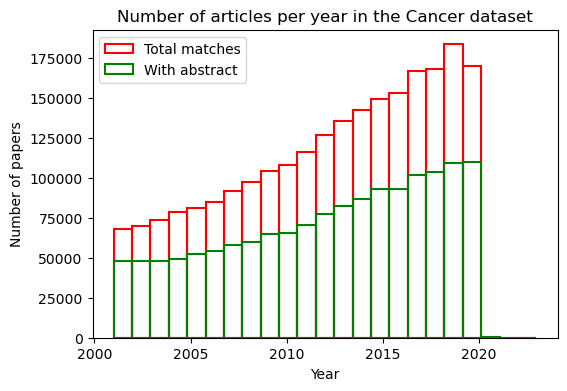

In [34]:
from matplotlib import pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(year_total, 23, ec='red', fc='none', lw=1.5, label='Total matches')
plt.hist(year_abstract, 23, ec='green', fc='none', lw=1.5, label='With abstract')
plt.legend(loc='upper left')
plt.title("Number of articles per year in the Cancer dataset")
plt.xlabel("Year")
plt.ylabel("Number of papers")
plt.show()

### Select according to list of keywords

In [43]:
with open("/export/clusterdata/jarenas/Datasets/semanticscholar/20230418/IA_keywords_SEAD_REV_JAG_JCS.txt", "r") as fin:
    AI_kwds = [el.strip() for el in fin.readlines()]
print('Number of keywords:', len(AI_kwds))

Number of keywords: 266


In [ ]:
dataset = (df_abstracts.join(df_papers, df_abstracts.corpusid ==  df_papers.corpusid, "inner")
                      .drop(df_papers.corpusid)
                ).cache()

print('Number of documents in dataset:', dataset.count())
dataset.printSchema()
dataset.show(n=2, truncate=120, vertical=True)

In [ ]:
def count_kwds(x):
    reps = [x.count(k) for k in AI_kwds]
    return sum(reps)

count_kwds_UDF = F.udf(count_kwds, IntegerType())

dataset = dataset.withColumn('raw_text', 
                    F.concat(F.col('title'),F.lit(' '), F.col('abstract')))

dataset = dataset.withColumn("Kwd_count", count_kwds_UDF(F.col("raw_text")))
dataset = dataset.filter(dataset.Kwd_count > 0).cache()

print('Number of documents in dataset:', dataset.count())
dataset.printSchema()
dataset.show(n=2, truncate=120, vertical=True)

In [ ]:
dataset.drop("raw_text").repartition(40).write.parquet(
    dir_parquet.joinpath(f"papers_AI_Kwds.parquet").as_posix(),
    mode="overwrite",
)

In [ ]:
year_AI = dataset.select("year").collect()

In [51]:
year_AI = [el[0] for el in year_AI if el[0]]
year_AI = [el for el in year_AI if el>2000]

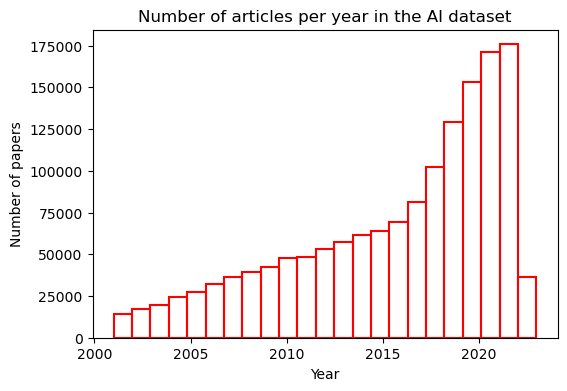

In [52]:
plt.figure(figsize=(6,4))
plt.hist(year_AI, 23, ec='red', fc='none', lw=1.5)
plt.title("Number of articles per year in the AI dataset")
plt.xlabel("Year")
plt.ylabel("Number of papers")
plt.show()

## Import the whole Semantic Scholar database for the IntelComp Data Catalogue

### Table **`papers`**

In [5]:
%%time
dir_papers = dir_data.joinpath('papers')
df_papers = spark.read.json('file:///' + dir_papers.as_posix())

#We drop corrupt records
df_papers = df_papers.cache()
df_papers = df_papers.where(F.col("_corrupt_record").isNull()).drop("_corrupt_record")

print('Number of papers available:', df_papers.count())
df_papers.printSchema()
df_papers.show(n=2, truncate=120, vertical=True)

Number of papers available: 211633022
root
 |-- authors: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- authorId: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |-- citationcount: long (nullable = true)
 |-- corpusid: long (nullable = true)
 |-- externalids: struct (nullable = true)
 |    |-- ACL: string (nullable = true)
 |    |-- ArXiv: string (nullable = true)
 |    |-- CorpusId: string (nullable = true)
 |    |-- DBLP: string (nullable = true)
 |    |-- DOI: string (nullable = true)
 |    |-- MAG: string (nullable = true)
 |    |-- PubMed: string (nullable = true)
 |    |-- PubMedCentral: string (nullable = true)
 |-- influentialcitationcount: long (nullable = true)
 |-- isopenaccess: boolean (nullable = true)
 |-- journal: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- pages: string (nullable = true)
 |    |-- volume: string (nullable = true)
 |-- publicationdate: string (nullable = true)

<span style="background-color:yellow;">The following code is used to count how many papers of each type are there in the dataset. It is very inefficient probably, but it works nevertheless.</span>

In [22]:
tipos = df_papers.where(F.col("publicationtypes").isNotNull()).select('publicationtypes').collect()
tipos = [el[0] for el in tipos]
tipos = [item for sublist in tipos for item in sublist]

from collections import Counter
counts = Counter(tipos)
print(counts)

Counter({'JournalArticle': 40043054, 'Review': 14740426, 'Conference': 3892498, 'Study': 2341448, 'CaseReport': 2183428, 'LettersAndComments': 1544547, 'Editorial': 665251, 'ClinicalTrial': 582213, 'Book': 280889, 'News': 239700, 'MetaAnalysis': 103700, 'Dataset': 727})


In [6]:
%%time

# This function will be used for extracting only the Semantic Scholar FOS in string format
# Semantic Scholar uses several models, but we keep only FOS from s2-fos-model
def extractFOS(x):
    try:
        return [el['category'] for el in x
            if el['source'] == "s2-fos-model"]
    except:
        return None
    
extractFOS_UDF = F.udf(extractFOS, ArrayType(StringType()))

# Adapt columns names and formats for backwards compatibility
dataset = df_papers.select(F.col('corpusid').alias('id'), \
                           'title', \
                           F.col('url').alias('S2Url'), \
                           F.col('year').cast(IntegerType()), \
                           F.col('externalids.DOI').alias('doi'), \
                           F.col('externalids.PubMed').alias('pmid'), \
                           F.col('externalids.MAG').alias('magId'), \
                           'externalids', \
                           extractFOS_UDF(F.col('s2fieldsofstudy')).alias("fieldsOfStudy"), \
                           'publicationtypes', \
                           'publicationdate', \
                           F.col('journal.name').alias('journalName'), \
                           F.col('journal.pages').alias('journalPages'), \
                           F.col('journal.volume').alias('journalVolume'), \
                           'venue', \
                           'publicationvenueid', \
                           'isopenaccess', \
                           F.col('referencecount').cast(IntegerType()), \
                           F.col('citationcount').cast(IntegerType()), \
                           F.col('influentialcitationcount').cast(IntegerType()) \
                          )
dataset.printSchema()
dataset.show(n=2, truncate=120, vertical=True)

root
 |-- id: long (nullable = true)
 |-- title: string (nullable = true)
 |-- S2Url: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- doi: string (nullable = true)
 |-- pmid: string (nullable = true)
 |-- magId: string (nullable = true)
 |-- externalids: struct (nullable = true)
 |    |-- ACL: string (nullable = true)
 |    |-- ArXiv: string (nullable = true)
 |    |-- CorpusId: string (nullable = true)
 |    |-- DBLP: string (nullable = true)
 |    |-- DOI: string (nullable = true)
 |    |-- MAG: string (nullable = true)
 |    |-- PubMed: string (nullable = true)
 |    |-- PubMedCentral: string (nullable = true)
 |-- fieldsOfStudy: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- publicationtypes: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- publicationdate: string (nullable = true)
 |-- journalName: string (nullable = true)
 |-- journalPages: string (nullable = true)
 |-- journalVolume: string (nullable = 

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id                       | 189035839                                                                                                                                             
 title                    | نقش شبکههای اجتماعی مجازی در راهبردهای یادگیری خودتنظیمی و رشد توانایی آیندهپژوهی دانشجویان                                                           
 S2Url                    | https://www.semanticscholar.org/paper/83f019e59aeb6fefe9d7d7490b3d72b125e8bda0                                                                        
 year                     | 2018                                                                                                                                                  
 doi                      | null                                                                         

In [7]:
%%time

dir_abstracts = dir_data.joinpath('abstracts')
df_abstracts = spark.read.json('file:///' + dir_abstracts.as_posix())

#We drop corrupt records
df_abstracts = df_abstracts.cache()
df_abstracts = df_abstracts.where(F.col("_corrupt_record").isNull()).drop("_corrupt_record")

print('Number of abstracts available:', df_abstracts.count())
df_abstracts.printSchema()
df_abstracts.show(n=2, truncate=120, vertical=True)

Number of abstracts available: 100048872
root
 |-- abstract: string (nullable = true)
 |-- corpusid: long (nullable = true)
 |-- openaccessinfo: struct (nullable = true)
 |    |-- externalids: struct (nullable = true)
 |    |    |-- ACL: string (nullable = true)
 |    |    |-- ArXiv: string (nullable = true)
 |    |    |-- DOI: string (nullable = true)
 |    |    |-- MAG: string (nullable = true)
 |    |    |-- PubMedCentral: string (nullable = true)
 |    |-- license: string (nullable = true)
 |    |-- status: string (nullable = true)
 |    |-- url: string (nullable = true)
 |-- updated: string (nullable = true)



-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 abstract       | Wspomnienie generala broni Tadeusza Buka, ktory zginąl w katastrofie pod Smolenskiem 10 kwietnia 2010 roku.                                                                                                                          
 corpusid       | 164091528                                                                                                                                                                                                                            
 openaccessinfo | {{null, null, null, 2338212559, null}, null, null, null}                                                                                                                                                                             
 updated

In [8]:
%%time

# Adapt columns names and formats for backwards compatibility
df_abstracts = df_abstracts.select(F.col('corpusid').alias('id'), \
                           F.col('abstract').alias('paperAbstract'), \
                           'openaccessinfo' \
                          )
df_abstracts.printSchema()
df_abstracts.show(n=2, truncate=120, vertical=True)

root
 |-- id: long (nullable = true)
 |-- paperAbstract: string (nullable = true)
 |-- openaccessinfo: struct (nullable = true)
 |    |-- externalids: struct (nullable = true)
 |    |    |-- ACL: string (nullable = true)
 |    |    |-- ArXiv: string (nullable = true)
 |    |    |-- DOI: string (nullable = true)
 |    |    |-- MAG: string (nullable = true)
 |    |    |-- PubMedCentral: string (nullable = true)
 |    |-- license: string (nullable = true)
 |    |-- status: string (nullable = true)
 |    |-- url: string (nullable = true)



-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id             | 164091528                                                                                                                                                                                                                            
 paperAbstract  | Wspomnienie generala broni Tadeusza Buka, ktory zginąl w katastrofie pod Smolenskiem 10 kwietnia 2010 roku.                                                                                                                          
 openaccessinfo | {{null, null, null, 2338212559, null}, null, null, null}                                                                                                                                                                             
-RECORD 

In [9]:
%%time

dataset = (dataset.join(df_abstracts, dataset.id ==  df_abstracts.id, "left")
                      .drop(df_abstracts.id)
                ).cache()

print('Number of documents in dataset:', dataset.count())
dataset.printSchema()
dataset.show(n=2, truncate=120, vertical=True)

23/05/20 18:46:56 ERROR TaskSchedulerImpl: Lost executor 3 on node70.cluster.tsc.uc3m.es: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/05/20 18:46:56 WARN TaskSetManager: Lost task 61.0 in stage 14.0 (TID 253) (node70.cluster.tsc.uc3m.es executor 3): ExecutorLostFailure (executor 3 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/05/20 18:46:56 WARN TaskSetManager: Lost task 58.0 in stage 14.0 (TID 250) (node70.cluster.tsc.uc3m.es executor 3): ExecutorLostFailure (executor 3 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/05/20 18:46:56 WARN TaskSetManager: Lost task 63.0 in stage 14.0 (TID 255) (node70.cluster.tsc.

Number of documents in dataset: 211633102
root
 |-- id: long (nullable = true)
 |-- title: string (nullable = true)
 |-- S2Url: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- doi: string (nullable = true)
 |-- pmid: string (nullable = true)
 |-- magId: string (nullable = true)
 |-- externalids: struct (nullable = true)
 |    |-- ACL: string (nullable = true)
 |    |-- ArXiv: string (nullable = true)
 |    |-- CorpusId: string (nullable = true)
 |    |-- DBLP: string (nullable = true)
 |    |-- DOI: string (nullable = true)
 |    |-- MAG: string (nullable = true)
 |    |-- PubMed: string (nullable = true)
 |    |-- PubMedCentral: string (nullable = true)
 |-- fieldsOfStudy: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- publicationtypes: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- publicationdate: string (nullable = true)
 |-- journalName: string (nullable = true)
 |-- journalPages: string (nullable = tru

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------
 id                       | 26                                                                                                                       
 title                    | FPGA-based design and implementation of an approximate polynomial matrix EVD algorithm                                   
 S2Url                    | https://www.semanticscholar.org/paper/7011b84b03f1d992962c4a6c87459f7742bc3165                                           
 year                     | 2012                                                                                                                     
 doi                      | 10.1109/FPT.2012.6412125                                                                                                 
 pmid                     | null                                                                    

In [10]:
%%time

dataset.write.parquet(
    dir_parquet.joinpath(f"papers.parquet").as_posix(),
    mode="overwrite",
)

23/05/20 18:58:10 ERROR TaskSchedulerImpl: Lost executor 1 on node65.cluster.tsc.uc3m.es: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/05/20 18:58:10 WARN TaskSetManager: Lost task 154.0 in stage 24.0 (TID 568) (node65.cluster.tsc.uc3m.es executor 1): ExecutorLostFailure (executor 1 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/05/20 18:58:10 WARN TaskSetManager: Lost task 50.0 in stage 24.0 (TID 594) (node65.cluster.tsc.uc3m.es executor 1): ExecutorLostFailure (executor 1 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/05/20 18:58:10 WARN TaskSetManager: Lost task 39.0 in stage 24.0 (TID 581) (node65.cluster.tsc

CPU times: user 421 ms, sys: 89 ms, total: 510 ms
Wall time: 8min 9s


In [39]:
print("Papers with PMID:", dataset.where(F.col("pmid").isNotNull()).count())
print("Papers with DOI:", dataset.where(F.col("doi").isNotNull()).count())
print("Unique DOIs:", dataset.where(F.col("doi").isNotNull()).select('doi').distinct().count())

23/05/21 01:44:16 ERROR TaskSchedulerImpl: Lost executor 19 on node17.cluster.tsc.uc3m.es: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/05/21 01:44:16 WARN TaskSetManager: Lost task 40.0 in stage 126.0 (TID 2412) (node17.cluster.tsc.uc3m.es executor 19): ExecutorLostFailure (executor 19 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/05/21 01:44:16 WARN TaskSetManager: Lost task 43.0 in stage 126.0 (TID 2415) (node17.cluster.tsc.uc3m.es executor 19): ExecutorLostFailure (executor 19 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/05/21 01:44:16 WARN TaskSetManager: Lost task 42.0 in stage 126.0 (TID 2414) (node17.c

Papers with PMID: 35659274


23/05/21 01:50:24 ERROR TaskSchedulerImpl: Lost executor 23 on node30.cluster.tsc.uc3m.es: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/05/21 01:50:24 WARN TaskSetManager: Lost task 50.0 in stage 133.0 (TID 2715) (node30.cluster.tsc.uc3m.es executor 23): ExecutorLostFailure (executor 23 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/05/21 01:50:24 WARN TaskSetManager: Lost task 117.0 in stage 133.0 (TID 2750) (node30.cluster.tsc.uc3m.es executor 23): ExecutorLostFailure (executor 23 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/05/21 01:50:24 WARN TaskSetManager: Lost task 63.0 in stage 133.0 (TID 2717) (node30.

Papers with DOI: 117413426


23/05/21 01:56:14 ERROR TaskSchedulerImpl: Lost executor 29 on node07.cluster.tsc.uc3m.es: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/05/21 01:56:14 WARN TaskSetManager: Lost task 80.0 in stage 140.0 (TID 2930) (node07.cluster.tsc.uc3m.es executor 29): ExecutorLostFailure (executor 29 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/05/21 01:56:14 WARN TaskSetManager: Lost task 96.0 in stage 140.0 (TID 2942) (node07.cluster.tsc.uc3m.es executor 29): ExecutorLostFailure (executor 29 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/05/21 01:56:14 WARN TaskSetManager: Lost task 98.0 in stage 140.0 (TID 2944) (node07.c

Unique DOIs: 115212769


----------------------------------------                                        
Exception occurred during processing of request from ('127.0.0.1', 33258)
Traceback (most recent call last):
  File "/usr/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/opt/spark-3.4.0-bin-3.3.1/python/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/opt/spark-3.4.0-bin-3.3.1/python/pyspark/accumulators.py", line 253, in poll
    if func():
  File "/opt/spark-3.4.0-bin-3.3.1/python/pyspark/accumulators.py", line 257, in accum_updates
    num_updates = read_in

### Table **`authors`**

In [12]:
%%time

dir_authors = dir_data.joinpath('authors')
df_authors = spark.read.json('file:///' + dir_authors.as_posix())

#We drop corrupt records
df_authors = df_authors.cache()
df_authors = df_authors.where(F.col("_corrupt_record").isNull()).drop("_corrupt_record")

print('Number of abstracts available:', df_authors.count())
df_authors.printSchema()
df_authors.show(n=2, truncate=120, vertical=True)

Number of abstracts available: 81067677
root
 |-- affiliations: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- aliases: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- authorid: string (nullable = true)
 |-- citationcount: long (nullable = true)
 |-- externalids: struct (nullable = true)
 |    |-- DBLP: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- ORCID: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |-- hindex: long (nullable = true)
 |-- homepage: string (nullable = true)
 |-- name: string (nullable = true)
 |-- papercount: long (nullable = true)
 |-- updated: string (nullable = true)
 |-- url: string (nullable = true)

-RECORD 0----------------------------------------------------------
 affiliations  | null                                              
 aliases       | null                                              
 authorid      | 135711444        

<span style="background-color:yellow;">Right now, it seems affiliations are missing, and ORCID also missing for most of the authors (<0.35%)? We will continue checking to see if this becomes any better.</span>

In [15]:
# Search for rows where the name column contains "John"
search_term = "J. Arenas-García"
result = df_authors.filter(F.col("name").like(f"%{search_term}%"))

result.show(truncate=120, vertical=True)

-RECORD 0---------------------------------------------------------------------------------------------------------------
 affiliations  | null                                                                                                   
 aliases       | [J Arenas-garcía, J. Arenas-garcia, Jeronimo Arenas-garcia, Jerónimo Arenas-garcía]                    
 authorid      | 1750044                                                                                                
 citationcount | 5                                                                                                      
 externalids   | null                                                                                                   
 hindex        | 1                                                                                                      
 homepage      | null                                                                                                   
 name          | J. Arenas-Garcí

In [17]:
print("Number of authors with affiliations:", df_authors.where(F.col("affiliations").isNotNull()).count())
print("Number of authors with ORCID:", df_authors.where(F.col("externalids.ORCID").isNotNull()).count())

Number of authors with affiliations: 283598


Number of authors with ORCID: 27299


In [ ]:
# Adapt columns names and formats for backwards compatibility
df_authors = df_authors.select(F.col('authorid').alias('id'), \
                               "name", \
                               "aliases", \
                               F.col('papercount').cast(IntegerType()), \
                               F.col('citationcount').cast(IntegerType()), \
                               F.col('hindex').cast(IntegerType()) \
                              )
df_authors.printSchema()
df_authors.show(n=2, truncate=120, vertical=True)

In [21]:
%%time

df_authors.write.parquet(
    dir_parquet.joinpath(f"authors.parquet").as_posix(),
    mode="overwrite",
)

CPU times: user 37.6 ms, sys: 0 ns, total: 37.6 ms
Wall time: 16.1 s


### Table **`paper_author`**

In [32]:
df_paper_author = df_papers.select(F.col('corpusid').alias('paper_id'), F.explode('authors'))
df_paper_author = df_paper_author.select('paper_id', F.col('col.authorId').alias('author_id'))

#We make sure that authors are in the author table
df_author_aux = df_authors.select("id")
df_paper_author = (
    df_paper_author.join(df_author_aux, \
                      df_paper_author.author_id ==  df_author_aux.id, "left")
                    .drop(df_author_aux.id)
).cache()

print("Number of paper_author entries:", df_paper_author.count())
df_paper_author.printSchema()
print(df_paper_author.show(n=2, vertical=True))

23/05/20 23:21:45 WARN CacheManager: Asked to cache already cached data.


Number of paper_author entries: 590620314
root
 |-- paper_id: long (nullable = true)
 |-- author_id: string (nullable = true)

-RECORD 0-------------
 paper_id  | 21187561 
 author_id | 10000172 
-RECORD 1-------------
 paper_id  | 7487231  
 author_id | 10000172 
only showing top 2 rows

None


In [33]:
# Save dataframe as parquet
df_paper_author.write.parquet(
    dir_parquet.joinpath("paper_author.parquet").as_posix(),
    mode="overwrite",
)


### Table **`citations`**

In [35]:
%%time 
dir_citations = dir_data.joinpath('citations')
df_citations = spark.read.json('file:///' + dir_citations.as_posix())

#We drop corrupt records
df_citations = df_citations.cache()
df_citations = df_citations.where(F.col("_corrupt_record").isNull()).drop("_corrupt_record")

#Select and rename some columns
#We skip the context (text surronding the citation) and intention (result, background, methods),
#since these data are most likely not going to be used in IntelComp

df_citations = df_citations.select(F.col('citingcorpusid').alias('source'), \
                                   F.col('citedcorpusid').alias('dest'), \
                                   'isinfluential')

print('Number of citations:', df_citations.count())
df_citations.printSchema()
df_citations.show(n=2, truncate=120, vertical=True)

23/05/21 00:28:34 ERROR TaskSchedulerImpl: Lost executor 17 on node14.cluster.tsc.uc3m.es: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/05/21 00:28:34 WARN TaskSetManager: Lost task 19.0 in stage 118.0 (TID 2284) (node14.cluster.tsc.uc3m.es executor 17): ExecutorLostFailure (executor 17 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/05/21 00:28:34 WARN TaskSetManager: Lost task 9.0 in stage 118.0 (TID 2274) (node14.cluster.tsc.uc3m.es executor 17): ExecutorLostFailure (executor 17 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
23/05/21 00:28:34 WARN TaskSetManager: Lost task 29.0 in stage 118.0 (TID 2294) (node14.cl

Number of citations: 2557754271
root
 |-- source: string (nullable = true)
 |-- dest: string (nullable = true)
 |-- isinfluential: boolean (nullable = true)



-RECORD 0------------------
 source        | 15824259  
 dest          | 26055095  
 isinfluential | false     
-RECORD 1------------------
 source        | 103110586 
 dest          | 98052377  
 isinfluential | false     
only showing top 2 rows

CPU times: user 853 ms, sys: 138 ms, total: 991 ms
Wall time: 56min 27s


In [36]:
%%time

# Save dataframe as parquet
df_citations.write.parquet(
    dir_parquet.joinpath("citations.parquet").as_posix(),
    mode="overwrite",
)

CPU times: user 286 ms, sys: 36.2 ms, total: 322 ms
Wall time: 17min 10s


## Legacy: Download PDFs (IN PROGRESS)

In [15]:
# Get previously downloaded pdfs
list_pdfs = set(
    [x.stem for x in dir_pdfs.iterdir() if x.is_file()]
)

# Select pdfs to download
pdf_urls = (
    df.select(["id", "pdfUrls"])
    .withColumn("pdfUrls", get_first_pdf("pdfUrls"))
    .filter(F.length("pdfUrls") > 0)
)
pdf_urls = pdf_urls.where(~F.col("id").isin(list_pdfs))

pdf_test = pdf_urls.limit(5)


FileNotFoundError: [Errno 2] No such file or directory: '/export/ml4ds/IntelComp/Datalake/SemanticScholar/rawdata/20220201/pdfs'

In [ ]:
## Download PDFs
#
# We download PDFs for all papers with valid a valid pdfUrl
# This option is not activated by default, since the number
# of papers to download would be huge
paper_download = 1

if paper_download:

    def download_pdfs(row, dir_pdfs=dir_pdfs):
        try:
            r = requests.get(row["pdfUrls"], stream=True)
            with dir_pdfs.joinpath(f"{row['id']}.pdf").open("wb") as f:
                f.write(r.content)
        except:
            pass

    pdf_test.foreach(download_pdfs)
